# VAE - MNIST

2022-08-05

Zooey Nguyen

- v1: just the Conv2Ds (plus the middle layers ofc)
- v2:  add MaxPooling2D
- v3: UpSampling2D+Conv2D to replace Conv2DTranspose with corresponding input decoder changes
- v4: ok it only produces blobs. going back to Conv2DTranspose and removing maxpooling, adding strides to all

## Setup

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
DATASET_NAME = "MNIST"
MODEL_TYPE = "VAE"
MODEL_VERSION = "v4"

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
dir_model = os.path.join('/models', model_id, 'model')
dir_checkpoints = os.path.join('/models', model_id, 'checkpoints')
dir_logs = os.path.join('/logs', model_id)
dir_predictions = os.path.join('/predictions', model_id)

print(dir_model)
print(dir_checkpoints)
print(dir_logs)
print(dir_predictions)

os.makedirs(dir_model, exist_ok=True)
os.makedirs(dir_checkpoints, exist_ok=True)
os.makedirs(dir_logs, exist_ok=True)
os.makedirs(dir_predictions, exist_ok=True)

/models/MNIST_VAE_v3/model
/models/MNIST_VAE_v3/checkpoints
/logs/MNIST_VAE_v3
/predictions/MNIST_VAE_v3


In [3]:
LATENT_DIM = 16
IMAGE_SHAPE = (28, 28, 1)
BATCH_SIZE = 128
EPOCHS = 40
GB_LIMIT = 5
CHECKPOINTS_TO_SAVE = 10

## Allocate GPU

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Data processing

Create a shuffled and batched dataset.

In [5]:
import os
from os.path import basename
from os import listdir
import h5py

In [6]:
from tensorflow.keras.datasets.mnist import load_data

train_df, test_df = load_data()
train_images, train_labels = train_df
train_gen = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)
train_gen = train_gen.map(lambda x: (x,x))
train_gen

<MapDataset shapes: ((None, 28, 28), (None, 28, 28)), types: (tf.uint8, tf.uint8)>

In [7]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

logs_callback = TensorBoard(log_dir=dir_logs)
weights_callback = ModelCheckpoint(filepath=os.path.join(dir_checkpoints, 'weights_epoch{epoch}.hdf5'),
                                   save_freq=int(EPOCHS/CHECKPOINTS_TO_SAVE),
                                   save_weights_only=True
                                  )
LR_callback = ReduceLROnPlateau()

## Metrics

## Variational autoencoder model

https://keras.io/examples/generative/vae/

https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/

### Define VAE

In [8]:
from tensorflow.keras.layers import Layer

class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
from tensorflow.keras.initializers import Zeros

class VAE(Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        images = Input(shape=IMAGE_SHAPE)
        x = Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same')(images)
        x = Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
        x = Flatten()(x)
        mean = Dense(LATENT_DIM, activation='relu')(x)
        logvar = Dense(LATENT_DIM, activation='relu', kernel_initializer='zeros')(x)
        samples = Sampling()([mean, logvar])
        self.encoder = Model(images, samples)

        latents = Input(shape=(LATENT_DIM,))
        x = Dense(7*7)(latents)
        x = Reshape(target_shape=(7,7,1))(x)
        x = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
        x = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
        x = Conv2DTranspose(1, kernel_size=3, activation='relu', padding='same')(x)
        outputs = Reshape(target_shape=IMAGE_SHAPE)(x)
        self.decoder = Model(latents, outputs)
 
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Create model

In [22]:
model = VAE()

In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Train model

In [24]:
history = model.fit(train_gen,
                    epochs=EPOCHS,
                    callbacks=[logs_callback, weights_callback],
                    verbose=1
                   )

Epoch 1/40
469/469 [==============================] - 3s 6ms/step - loss: 3007.6277
Epoch 2/40
469/469 [==============================] - 3s 6ms/step - loss: 1901.2810
Epoch 3/40
469/469 [==============================] - 3s 6ms/step - loss: 1725.2446
Epoch 4/40
469/469 [==============================] - 3s 6ms/step - loss: 1644.6663
Epoch 5/40
469/469 [==============================] - 3s 6ms/step - loss: 1596.3063
Epoch 6/40
469/469 [==============================] - 3s 6ms/step - loss: 1562.7722
Epoch 7/40
469/469 [==============================] - 3s 6ms/step - loss: 1538.0967
Epoch 8/40
469/469 [==============================] - 3s 6ms/step - loss: 1519.5358
Epoch 9/40
469/469 [==============================] - 3s 6ms/step - loss: 1503.6600
Epoch 10/40
469/469 [==============================] - 3s 6ms/step - loss: 1489.9690
Epoch 11/40
469/469 [==============================] - 3s 6ms/step - loss: 1477.9939
Epoch 12/40
469/469 [==============================] - 3s 6ms/step - loss:

### Save model

In [25]:
model.save(dir_model)

INFO:tensorflow:Assets written to: /models/MNIST_VAE_v3/model/assets


## Evaluate model

In [26]:
for sample in train_gen.take(1):
    images, labels = sample
    predictions = model.predict(images)

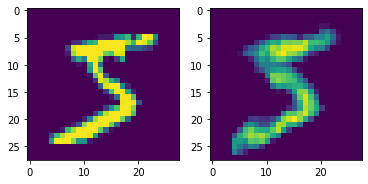

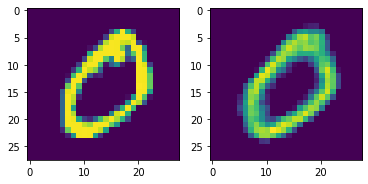

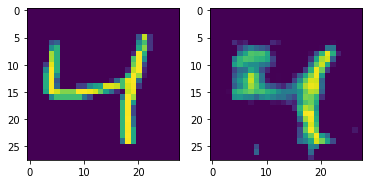

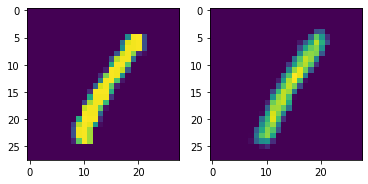

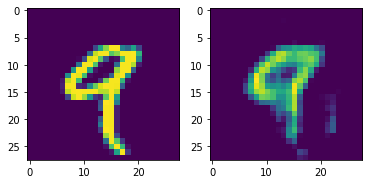

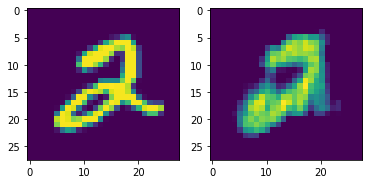

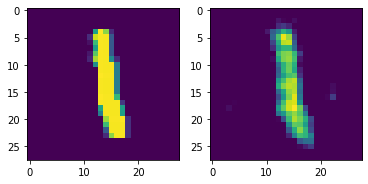

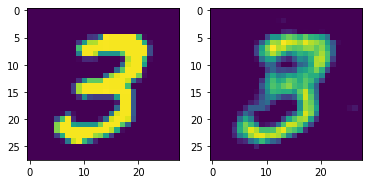

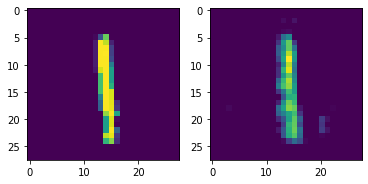

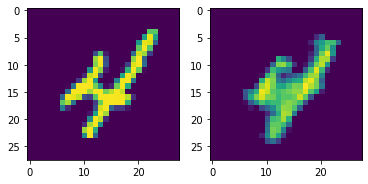

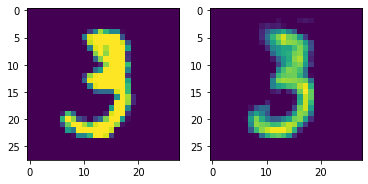

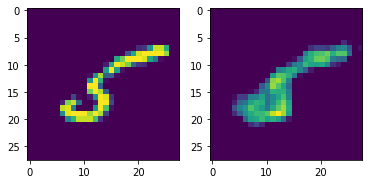

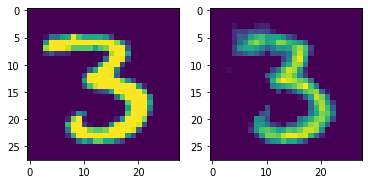

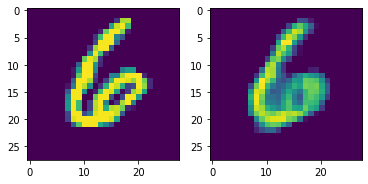

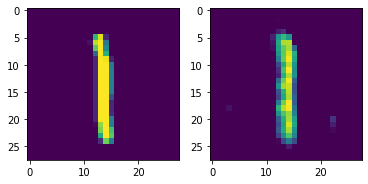

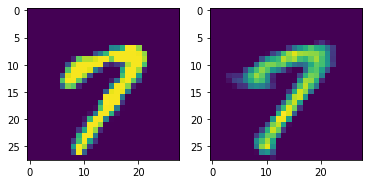

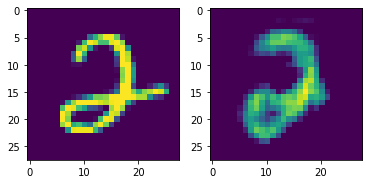

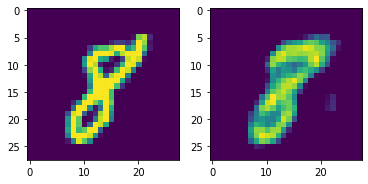

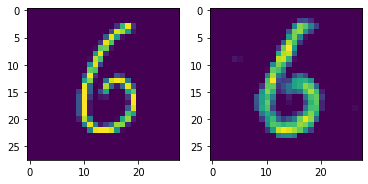

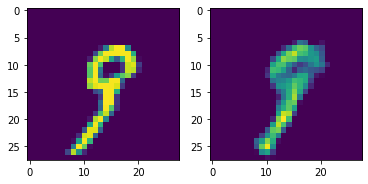

In [27]:
for i in range(20):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(images[i])
    ax[1].imshow(predictions[i])